In [67]:
""" Versión 'notebook' del scrip .py """

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import xgboost as xgb
from datetime import datetime

from sklearn.metrics import roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.metrics import ConfusionMatrixDisplay

from collections import OrderedDict
from importlib import reload

from lib.main_func_p1 import path
from lib.main_func_p3 import calculate_onefp
from lib.main_func_p4 import model_clf
from lib.main_func_p4 import modelXGBoost_fit_scores
from lib.main_func_p4 import resampling_set
from lib.main_func_p4 import plot_ROC_curve

In [68]:
def imgs_to_pdf(img_dir, save_dir=None, save_name=None, res=400):
    from img2pdf import convert
    list_images = list()
    for file in os.listdir(img_dir):
        try:
            checker = file.rsplit('_')[1]
        except IndexError:
            checker = ''
        if checker == 'summary':
            list_images.append(f'{img_dir}/{file}')
    with open(f'{save_dir}/{save_name}', 'wb') as pdf:
        pdf.write(convert(list_images))

In [69]:
#####################################
# proteina (uniprot_ID)
uniprot_id = 'P56817' # Solmante es necesario cambiar la proteina

# Parametros
path_file = path(uniprot_id)
seed = 142854
fp_name = 'morgan2_c'
all_type=False
save=True

Datos de proteína cargados
Archivos a procesar: 16
>> PROCESO INICIADO <<
> 1/16: P56817 - f1_weighted - 0
>> P56817_summary_f1_weighted_0.png: SAVED


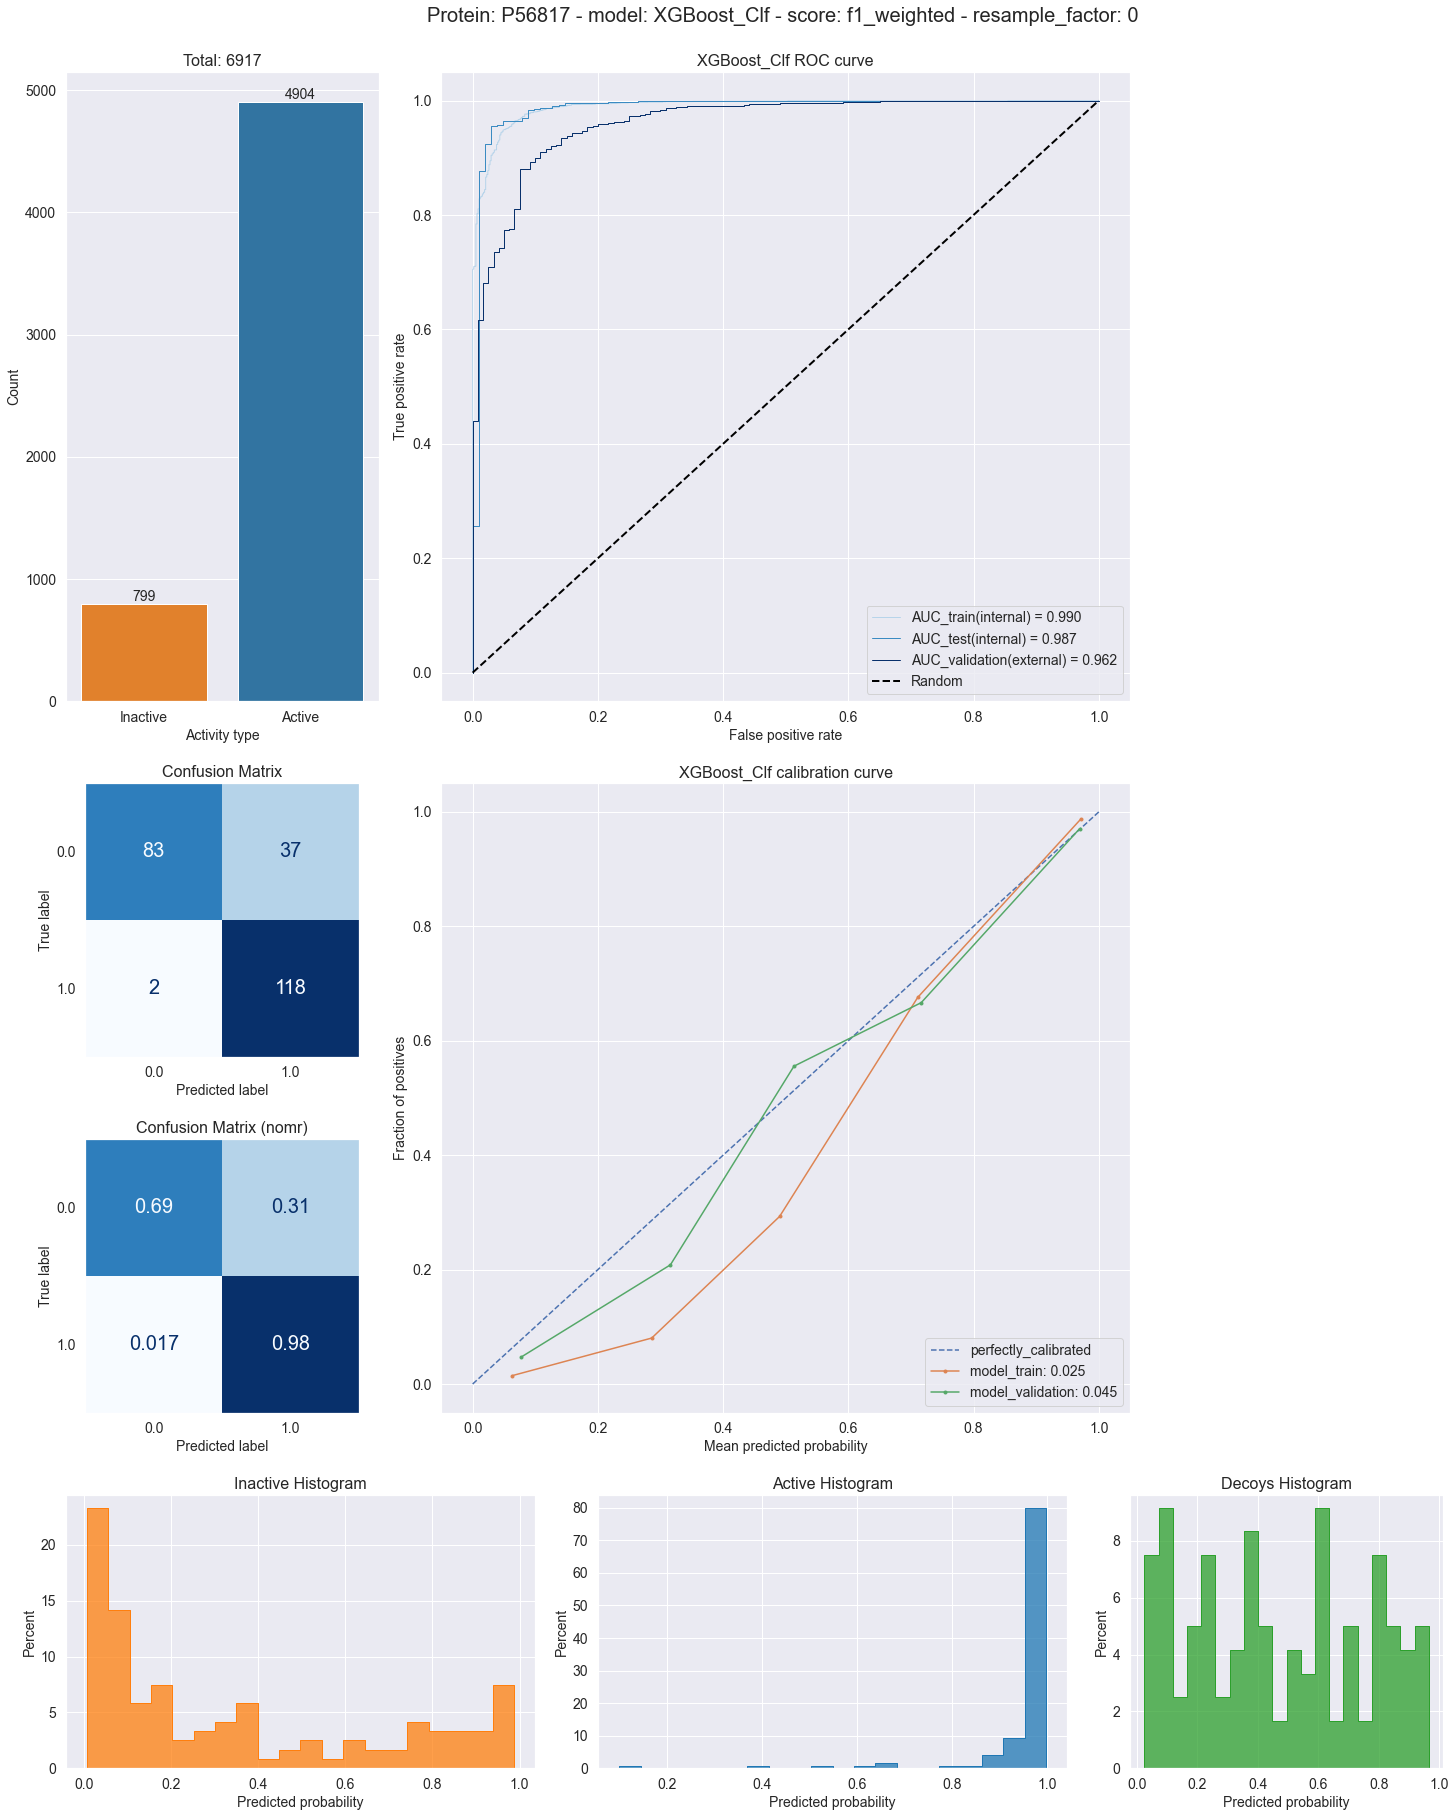

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


>> DONE <<


In [82]:
# List of files in top_scores/uniprot_id
list_excelfiles_to_process = []
for file in os.listdir(f'./top_scores/{uniprot_id}'):
    list_excelfiles_to_process.append(file)
total_files = len(list_excelfiles_to_process)
# Load and read the set universe
ADME_df = pd.read_csv(f'{path_file}_02_ligands_smiles_ADME_lipinski.csv')

print(f'Datos de proteína cargados\n'
      f'Archivos a procesar: {total_files}\n'
      f'>> PROCESO INICIADO <<')

for index, excel_file in enumerate(list_excelfiles_to_process[:1]):
    # Load top_scores Excel file (one by one)
    top_scores = pd.read_excel(f'./top_scores/{uniprot_id}/{excel_file}')
    # params
    score_metric = '_'.join(str.split(excel_file, '_')[5:-1])
    resample_factor = int(str.split(excel_file, '_')[-1][2:][:-5])
    resample_mode = 'under_sampling'
    model_name = f'XGBoost_Clf'
    print(f'> {index+1}/{total_files}: {uniprot_id} - {score_metric} - {resample_factor}')

    # export image name
    img_name = f'{score_metric}_{resample_factor}.png'

    # Load train and validation datasets
    df_train = pd.read_pickle(f'{path_file}_dataset_train')
    df_valid = pd.read_pickle(f'{path_file}_dataset_valid')
    X_valid, y_valid = df_valid[fp_name].tolist(), df_valid['activity'].tolist()

    eval_metric = ['error', 'auc']
    params_dict = dict(eval(top_scores.params_dict[0]))
    default_params_xgb = {'booster': 'gbtree', 'tree_method': 'gpu_hist',
                          'objective': 'binary:logistic', 'grow_policy': 'depthwise',
                          'eval_metric': eval_metric, 'early_stopping_rounds': 10}
    params_dict.update(default_params_xgb)

    # train and save the 'best' model
    xgbc_tuned = xgb.XGBClassifier(**params_dict)
    # Train model and evaluating scores (train / validation)
    xgbc_tuned, scores_train, scores_valid = modelXGBoost_fit_scores(xgbc_tuned, fp_name, df_train, df_valid,
                                                                     resample_factor=resample_factor,
                                                                     resample_mode=resample_mode, verbose=False)
    xgbc_tuned.save_model(f'./models/{uniprot_id}_model.ubj')
    xgbc_tuned, df_results_model_tuned, results_ROC_fp = model_clf(xgbc_tuned, fp_name, uniprot_id, seed=seed,
                                                                   save_log=True, verbose=False)

    # Calcular probabilidades del conjunto de datos externo
    pred_valid = xgbc_tuned.predict(X_valid)
    df_valid['prediction'] = pred_valid

    prediction_prob_valid = np.array(xgbc_tuned.predict_proba(X_valid)[:, 1])
    df_valid['prediction_prob'] = prediction_prob_valid

    # metricas
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, prediction_prob_valid)
    auc_score_unseen = auc(fpr_valid, tpr_valid)
    metrics_ROC_valid = (fpr_valid, tpr_valid, auc_score_unseen)
    metrics_ROC = results_ROC_fp.copy()
    metrics_ROC.extend([metrics_ROC_valid])
    metrics_ROC_name = ['train(internal)', 'test(internal)', 'validation(external)']

    # Decoys
    decoy_samples = min(list(df_valid.activity.value_counts()))
    df_decoys = pd.DataFrame(columns=['smiles'])
    list_d = list()
    decoys_len = int(decoy_samples)
    with open(f'data/_decoys/{uniprot_id}_all_smiles.ism', 'rb') as f:
        decoys_line = f.readlines()
        for line in decoys_line[1:]:  # first line: header
            line = line.decode('UTF-8').split()
            list_d.append(line)
    df_decoys = pd.DataFrame(list_d, columns=['smiles', 'id'])
    df_decoys = df_decoys.sample(n=decoys_len, ignore_index=True)
    calculate_onefp(df_decoys, fp_name)
    df_decoys.drop_duplicates(subset=['smiles'], inplace=True)
    df_decoys.reset_index(inplace=True, drop=True)
    df_decoys = df_decoys.drop(['mol'], axis=1)
    df_decoys = df_decoys.drop(['smiles'], axis=1)
    df_decoys['type'] = 'decoy'
    df_decoys = df_decoys[['type', fp_name]]
    x_decoy = df_decoys[fp_name].tolist()
    pred_decoy = xgbc_tuned.predict(x_decoy)
    prediction_prob = xgbc_tuned.predict_proba(x_decoy)[:, 1]
    prediction_prob = np.array(prediction_prob)
    df_decoys['activity'] = 0.0
    df_decoys['prediction'] = pred_decoy
    df_decoys['prediction_prob'] = prediction_prob

    # Resample
    df_valid_rsmpl = resampling_set(df_valid, mode='under_sampling', ratio=1)
    df_valid_rsmpl['type'] = 'valid_inactive'
    df_valid_rsmpl.loc[df_valid_rsmpl[df_valid_rsmpl.activity == 1.0].index, 'type'] = 'valid_active'
    df_valid_rsmpl.reset_index(drop=True, inplace=True)
    df_valid_rsmpl = df_valid_rsmpl[['type', fp_name, 'activity', 'prediction', 'prediction_prob']]
    X_valid_rsmpl, y_valid_rsmpl = df_valid_rsmpl[fp_name].tolist(), df_valid_rsmpl['activity'].tolist()

    # Datos Calibración
    df_internal = pd.read_pickle(f'{path_file}_dataset_train')
    X_test, y_test = df_internal[fp_name].tolist(), df_internal['activity'].tolist()
    pred_test = xgbc_tuned.predict(X_test)
    df_internal['prediction'] = pred_test

    prediction_prob_test = np.array(xgbc_tuned.predict_proba(X_test)[:, 1])
    df_internal['prediction_prob'] = prediction_prob_test

    sns.set_theme()
    title_size, normal_size = 16, 14
    grid_rows, grid_columns = 6, 4
    figure, axes = plt.subplots(grid_rows, grid_columns, figsize=(20, 30))
    gs = GridSpec(grid_rows, grid_columns, figure=figure)
    gs_2 = GridSpec(grid_rows, grid_columns, figure=figure, width_ratios=[1.5, 1.5, 1, 0])
    figure.suptitle(
        f'Protein: {uniprot_id} - model: {model_name} - score: {score_metric} - resample_factor: {resample_factor} ',
        size=20)
    for i in range(grid_rows):
        for j in range(grid_columns):
            axes[i, j].remove()
    axes[0, 0] = figure.add_subplot(gs[:2, 0])
    axes[0, 1] = figure.add_subplot(gs[:2, 1:3])
    axes[2, 0] = figure.add_subplot(gs[2:3, 0:1])
    axes[3, 0] = figure.add_subplot(gs[3:4, 0:1])
    axes[2, 1] = figure.add_subplot(gs[2:4, 1:3])
    axes[4, 0] = figure.add_subplot(gs_2[4:5, 0:1])
    axes[4, 2] = figure.add_subplot(gs_2[4:5, 1:2])
    axes[4, 3] = figure.add_subplot(gs_2[4:5, 2:3])

    # 1. Plot  count active /inactive
    if all_type:
        sns.countplot(ax=axes[0, 0], x='activity_type', data=ADME_df, order=['Inactive', 'Intermediate', 'Active'])
    else:
        sns.countplot(ax=axes[0, 0], x='activity_type', data=ADME_df, order=['Inactive', 'Active'],
                      palette=['tab:orange', "tab:blue"])
    axes[0, 0].set_title(f'Total: {len(ADME_df)}', fontsize=title_size)
    axes[0, 0].bar_label(container=axes[0, 0].containers[0], fmt='%g', fontsize=normal_size)
    axes[0, 0].set_xlabel('Activity type', size=normal_size)
    axes[0, 0].set_ylabel('Count', size=normal_size)
    axes[0, 0].tick_params(labelsize=normal_size)
    # -------------------------------

    # 2. Plot  ROC curve
    cmap = cm.get_cmap('Blues')
    colors = [cmap(i) for i in np.linspace(0.3, 1.0, len(metrics_ROC))]
    for i, metrics in enumerate(metrics_ROC):
        fpr, tpr, roc_auc = metrics[0], metrics[1], metrics[2]
        name = metrics_ROC_name[i]
        axes[0, 1].plot(fpr, tpr, lw=1, color=colors[i], label='AUC_{} = {:.3f}'.format(name, roc_auc))

    axes[0, 1].plot([0, 1], [0, 1], linestyle='--', label='Random', lw=2, color="black")  # Random curve
    axes[0, 1].set_xlabel('False positive rate', size=normal_size)
    axes[0, 1].set_ylabel('True positive rate', size=normal_size)
    axes[0, 1].set_title(model_name + ' ROC curve', size=title_size)
    axes[0, 1].tick_params(labelsize=normal_size)
    axes[0, 1].legend(fontsize=normal_size, loc='lower right')

    # 3. Calibration curve
    df_plots_list = [df_internal, df_valid]
    list_plots_name = ['model_train', 'model_validation']
    axes[2, 1].plot([0, 1], [0, 1], linestyle='--', label='perfectly_calibrated')

    for i, df in enumerate(df_plots_list):
        clf_score = round(brier_score_loss(df['activity'], df['prediction_prob'], pos_label=1), 3)
        fop, mpv = calibration_curve(df['activity'], df['prediction_prob'], n_bins=5)
        name = list_plots_name[i]
        # plot model reliability
        axes[2, 1].plot(mpv, fop, marker='.', label=f'{name}: {clf_score}')

    axes[2, 1].set_xlabel('Mean predicted probability', size=normal_size)
    axes[2, 1].set_ylabel('Fraction of positives', size=normal_size)
    axes[2, 1].set_title(model_name + ' calibration curve', size=title_size)
    axes[2, 1].tick_params(labelsize=normal_size)
    axes[2, 1].legend(fontsize=normal_size, loc='lower right')

    # 4 Confusion Matrix'
    plt.rc('font', size=20)
    disp1 = ConfusionMatrixDisplay.from_estimator(xgbc_tuned, X_valid_rsmpl, y_valid_rsmpl,
                                                  cmap=plt.cm.Blues, normalize=None,
                                                  colorbar=False, ax=axes[2, 0])
    axes[2, 0].grid(False)
    axes[2, 0].tick_params(labelsize=normal_size)
    axes[2, 0].set_xlabel('Predicted label', size=normal_size)
    axes[2, 0].set_ylabel('True label', size=normal_size)
    axes[2, 0].set_title('Confusion Matrix', size=title_size)

    disp2 = ConfusionMatrixDisplay.from_estimator(xgbc_tuned, X_valid_rsmpl, y_valid_rsmpl,
                                                  cmap=plt.cm.Blues, normalize='true',
                                                  colorbar=False, ax=axes[3, 0])
    axes[3, 0].grid(False)
    axes[3, 0].tick_params(labelsize=normal_size)
    axes[3, 0].set_xlabel('Predicted label', size=normal_size)
    axes[3, 0].set_ylabel('True label', size=normal_size)
    axes[3, 0].set_title('Confusion Matrix (nomr)', size=title_size)
    plt.rc('font', size=8)

    # 5. Probability prediction Histogram
    # Unir decoys + resample
    df_inactive = df_valid_rsmpl[df_valid_rsmpl['type'] == 'valid_inactive']
    sns.histplot(ax=axes[4, 0], data=df_inactive, x="prediction_prob", bins=20, stat='percent', element="step",
                 color='tab:orange')
    axes[4, 0].tick_params(labelsize=normal_size)
    axes[4, 0].set_xlabel('Predicted probability', size=normal_size)
    axes[4, 0].set_ylabel('Percent', size=normal_size)
    axes[4, 0].set_title('Inactive Histogram', size=title_size)

    df_active = df_valid_rsmpl[df_valid_rsmpl['type'] == 'valid_active']
    sns.histplot(ax=axes[4, 2], data=df_active, x="prediction_prob", bins=20, stat='percent', element="step",
                 color='tab:blue')
    axes[4, 2].tick_params(labelsize=normal_size)
    axes[4, 2].set_xlabel('Predicted probability', size=normal_size)
    axes[4, 2].set_ylabel('Percent', size=normal_size)
    axes[4, 2].set_title('Active Histogram', size=title_size)

    sns.histplot(ax=axes[4, 3], data=df_decoys, x="prediction_prob", bins=20, stat='percent', element="step",
                 color='tab:green')
    axes[4, 3].tick_params(labelsize=normal_size)
    axes[4, 3].set_xlabel('Predicted probability', size=normal_size)
    axes[4, 3].set_ylabel('Percent', size=normal_size)
    axes[4, 3].set_title('Decoys Histogram', size=title_size)

    # set the spacing between subplots
    plt.subplots_adjust(left=0, bottom=0, right=1, top=0.95, wspace=0.2, hspace=0.3)
    plt.savefig(f'{path_file}_summary_{img_name}', bbox_inches='tight')
    print(f'>> {uniprot_id}_summary_{img_name}: SAVED')

    plt.show()
    plt.close()
img_dir = save_dir = f'./data/{uniprot_id}'
save_name = f'SUMMARY_{uniprot_id}.pdf'
imgs_to_pdf(img_dir, save_dir, save_name)
print('>> DONE <<')
